# 관광객 수 예측 모델 성능 보고서

#####  필요한 패키지 준비

In [4]:
pip install numpy pandas matplotlib seaborn scikit-learn xgboost 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Data Load

###  데이터 기본 정보 파악

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

#데이터 불러오기
df = pd.read_csv('dataset_with_subway.csv')

print(f"데이터 크기: {df.shape}")
print(f"행정동 수: {df['ADSTRD_CODE_SE'].nunique()}개")

데이터 크기: (5840, 18)
행정동 수: 16개


In [7]:
# 결측치
df.isnull().sum()

STDR_DE_ID                0
ADSTRD_CODE_SE            0
TOT_LVPOP_CO              0
culture_event_count       0
분류                     3521
유무료                    3521
has_culture_event         0
is_holiday                0
avg_temp                  0
max_temp                  0
min_temp                  0
precipitation          3280
wind_speed                0
sunshine_hours           16
humidity                  0
ground_temp               0
subway_inflow             0
subway_outflow            0
dtype: int64

In [8]:
# 기초 통계 요약
df.describe()

,STDR_DE_ID,ADSTRD_CODE_SE,TOT_LVPOP_CO,culture_event_count,has_culture_event,is_holiday,avg_temp,max_temp,min_temp,precipitation,wind_speed,sunshine_hours,humidity,ground_temp,subway_inflow,subway_outflow
count,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,2560.000000,5840.000000,5824.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2.024396e+07,1.136376e+07,50324.270295,1.357021,0.397089,0.046575,14.373425,19.122740,10.367397,8.201250,2.324658,6.573901,64.292329,15.501096,71652.606164,69750.497603
std,4.420607e+03,2.235091e+05,41398.275711,3.170137,0.489337,0.210746,10.994450,11.015693,11.215887,17.802933,0.656151,3.996001,13.241330,12.153244,52554.862606,51008.402408
min,2.024050e+07,1.111062e+07,6415.227500,0.000000,0.000000,0.000000,-9.700000,-6.100000,-12.200000,0.000000,1.200000,0.000000,29.400000,-5.300000,4076.000000,3409.000000
25%,2.024073e+07,1.116304e+07,21717.047475,0.000000,0.000000,0.000000,3.900000,8.200000,0.400000,0.000000,1.800000,3.075000,54.100000,2.800000,23058.750000,22116.250000
50%,2.024103e+07,1.132068e+07,33705.186400,0.000000,0.000000,0.000000,15.500000,21.400000,11.400000,0.700000,2.200000,7.300000,64.600000,16.200000,59286.000000,57959.000000
75%,2.025013e+07,1.157564e+07,60822.933675,1.000000,1.000000,0.000000,24.400000,28.300000,21.300000,7.025000,2.700000,9.625000,74.100000,26.500000,93940.750000,93993.750000
max,2.025043e+07,1.171058e+07,191187.196400,23.000000,1.000000,1.000000,31.800000,36.400000,28.200000,128.800000,6.300000,13.500000,95.300000,37.200000,237061.000000,206455.000000


### Visualization 및 EDA

C:\Users\LG\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LG\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


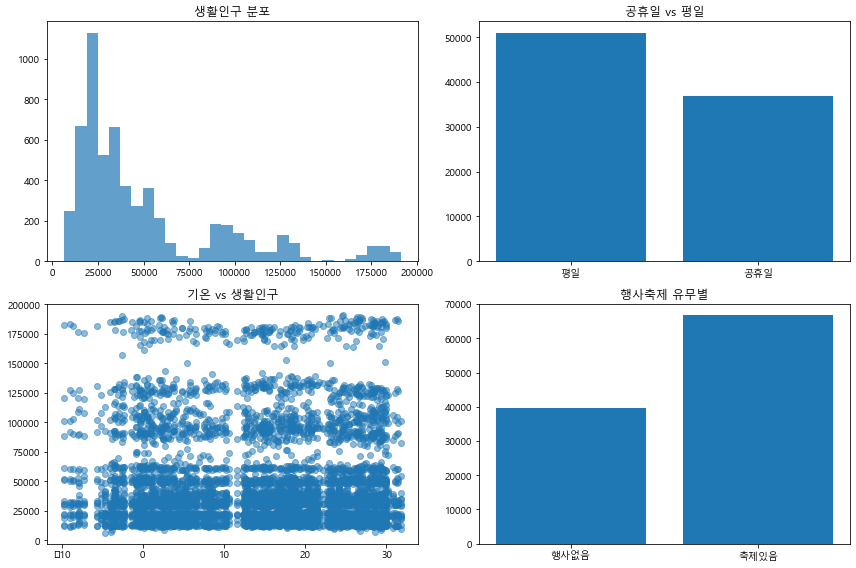

In [9]:
# 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2x2 그리드
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. 생활인구 분포
axes[0,0].hist(df['TOT_LVPOP_CO'], bins=30, alpha=0.7)
axes[0,0].set_title('생활인구 분포')

# 2. 공휴일 vs 평일
holiday_avg = df.groupby('is_holiday')['TOT_LVPOP_CO'].mean()
axes[0,1].bar(['평일', '공휴일'], holiday_avg.values)
axes[0,1].set_title('공휴일 vs 평일')

# 3. 기온 vs 생활인구
axes[1,0].scatter(df['avg_temp'], df['TOT_LVPOP_CO'], alpha=0.5)
axes[1,0].set_title('기온 vs 생활인구')

# 4. 문화행사 유무
event_avg = df.groupby('has_culture_event')['TOT_LVPOP_CO'].mean()
axes[1,1].bar(['행사없음', '축제있음'], event_avg.values)
axes[1,1].set_title('행사축제 유무별')

plt.tight_layout()
plt.show()

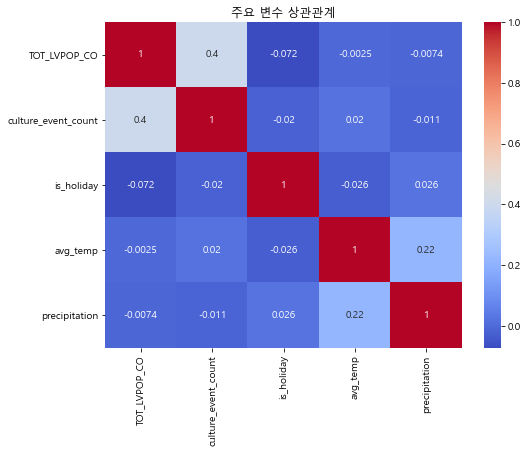

In [10]:
# 상관관계 히트맵
plt.figure(figsize=(8, 6))
cols = ['TOT_LVPOP_CO', 'culture_event_count', 'is_holiday', 'avg_temp', 'precipitation']
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.title('주요 변수 상관관계')
plt.show()

In [11]:
print(f"공휴일 평균: {df[df['is_holiday']==1]['TOT_LVPOP_CO'].mean():.0f}명")
print(f"평일 평균: {df[df['is_holiday']==0]['TOT_LVPOP_CO'].mean():.0f}명")
print(f"문화행사 있을 때: {df[df['has_culture_event']==1]['TOT_LVPOP_CO'].mean():.0f}명")
print(f"문화행사 없을 때: {df[df['has_culture_event']==0]['TOT_LVPOP_CO'].mean():.0f}명")

공휴일 평균: 36792명
평일 평균: 50985명
문화행사 있을 때: 66731명
문화행사 없을 때: 39518명


### 데이터 전처리

In [12]:
#주말 포함 공휴일 처리
df['STDR_DE_ID'] = pd.to_datetime(df['STDR_DE_ID'], format='%Y%m%d')
df['weekday'] = df['STDR_DE_ID'].dt.weekday  # 0=월, 6=일
df['is_holiday'] = np.where((df['is_holiday'] == 1) | (df['weekday'] >= 5), 1, 0)

#계절성 반영 위한 달 정보 추가
df['month'] = df['STDR_DE_ID'].dt.month

#불필요한 feature 제거
df = df.drop(['subway_inflow', 'subway_outflow', 'weekday'], axis=1)

# 문화행사 카테고리화: 무료(2), 유료(1), 없음(0)
df['event_type'] = 0

#행사 있는 행만 선택
event_rows = df['culture_event_count'] > 0

# 유무료 매핑
df.loc[event_rows & (df['유무료'] == '무료'), 'event_type'] = 2
df.loc[event_rows & (df['유무료'].notna()) & (df['유무료'] != '무료'), 'event_type'] = 1


#필요하면 '유무료'와 '분류' 컬럼 제거
df = df.drop(columns=['유무료', '분류'])


#강수량 결측치 처리
df['precipitation'] = df['precipitation'].fillna(0)

#일조량 결측치 처리
df['sunshine_hours'] = df['sunshine_hours'].fillna(0)

#culture_event_count 조건부 처리
df['has_culture_event'] = np.where(df['culture_event_count'] > 0, 1, 0)

In [13]:
df.isnull().sum()

STDR_DE_ID             0
ADSTRD_CODE_SE         0
TOT_LVPOP_CO           0
culture_event_count    0
has_culture_event      0
is_holiday             0
avg_temp               0
max_temp               0
min_temp               0
precipitation          0
wind_speed             0
sunshine_hours         0
humidity               0
ground_temp            0
month                  0
event_type             0
dtype: int64

In [14]:
df.shape

(5840, 16)

# Modeling

## 행정동별 개별 모델

### XGBoost

In [15]:
dong_names = {
    '11110615': '종로1·2·3·4가동',
    '11110650': '혜화동',
    '11140550': '명동',
    '11140605': '을지로동',
    '11170520': '용산2가동',
    '11170650': '이태원1동',
    '11200660': '성수1가제2동(뚝섬)',
    '11200690': '성수2가제3동',
    '11440660': '서교동',
    '11440690': '망원제1동',
    '11440710': '연남동',
    '11560605': '문래동',
    '11620745': '삼성동',
    '11680510': '신사동',
    '11680640': '역삼1동',
    '11710580': '송파1동'
}

In [16]:
results = []

#행정동별 모델 학습
for code, group in df.groupby('ADSTRD_CODE_SE'):
    print(f"행정동 {code} 모델 학습 시작")

    #target scaling
    scaler = MinMaxScaler()
    group['TOT_LVPOP_CO_SCALED'] = scaler.fit_transform(group[['TOT_LVPOP_CO']])

    #features
    features = [
        'event_type',
        'culture_event_count',
        'is_holiday',
        'month',
        'avg_temp',
        'max_temp',
        'min_temp',
        'precipitation',
        'wind_speed',
        'humidity',
        'ground_temp'
    ]

    X = group[features]
    y = group['TOT_LVPOP_CO_SCALED']

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # model
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        objective='reg:squarederror'
    )
    model.fit(X_train, y_train)

    # evaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_test, y_pred)

    print(f"행정동 {code} RMSE: {rmse:.4f}, R2: {r2:.4f}")
    results.append({
        'ADSTRD_CODE_SE': code,
        'RMSE': rmse,
        'R2': r2
    })

#결과 DataFrame
results_df = pd.DataFrame(results)
results_df['행정동'] = results_df['ADSTRD_CODE_SE'].astype(str).map(dong_names)
print("\n전체 결과:")
print(results_df)

행정동 11110615 모델 학습 시작
행정동 11110615 RMSE: 0.1563, R2: 0.6120
행정동 11110650 모델 학습 시작
행정동 11110650 RMSE: 0.0810, R2: 0.3839
행정동 11140550 모델 학습 시작
행정동 11140550 RMSE: 0.1413, R2: 0.7629
행정동 11140605 모델 학습 시작
행정동 11140605 RMSE: 0.1048, R2: 0.8835
행정동 11170520 모델 학습 시작
행정동 11170520 RMSE: 0.1201, R2: 0.5831
행정동 11170650 모델 학습 시작
행정동 11170650 RMSE: 0.2049, R2: 0.5559
행정동 11200660 모델 학습 시작
행정동 11200660 RMSE: 0.0876, R2: 0.8229
행정동 11200690 모델 학습 시작
행정동 11200690 RMSE: 0.0963, R2: 0.8876
행정동 11440660 모델 학습 시작
행정동 11440660 RMSE: 0.1267, R2: 0.0650
행정동 11440690 모델 학습 시작
행정동 11440690 RMSE: 0.1066, R2: 0.3438
행정동 11440710 모델 학습 시작
행정동 11440710 RMSE: 0.1303, R2: 0.4005
행정동 11560605 모델 학습 시작
행정동 11560605 RMSE: 0.1070, R2: 0.6916
행정동 11620745 모델 학습 시작
행정동 11620745 RMSE: 0.0806, R2: 0.4331
행정동 11680510 모델 학습 시작
행정동 11680510 RMSE: 0.1337, R2: 0.2956
행정동 11680640 모델 학습 시작
행정동 11680640 RMSE: 0.1106, R2: 0.8523
행정동 11710580 모델 학습 시작
행정동 11710580 RMSE: 0.1132, R2: -0.0153

전체 결과:
    ADSTRD_CODE_SE      RMSE   

##### -->모델 설명력이 대체로 낮고, 송파1동의 경우는 음수의 R2값까지 가짐

### Random Forest with Grid Search

In [17]:
results = []
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
for code, group in df.groupby('ADSTRD_CODE_SE'):
    print(f"행정동 {code} 모델 학습 시작")
    scaler = MinMaxScaler()
    group.loc[:, 'TOT_LVPOP_CO_SCALED'] = scaler.fit_transform(group[['TOT_LVPOP_CO']])
    features = [
        'event_type',
        'culture_event_count',
        'is_holiday',
        'month',
        'avg_temp',
        'max_temp',
        'min_temp',
        'precipitation',
        'wind_speed',
        'humidity',
        'ground_temp'
    ]
    X = group[features]
    y = group['TOT_LVPOP_CO_SCALED']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,  # 3-fold cross-validation
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"행정동 {code} Best Params: {grid_search.best_params_}")
    print(f"행정동 {code} RMSE: {rmse:.4f}, R2: {r2:.4f}")

    results.append({
        'ADSTRD_CODE_SE': code,
        'RMSE': rmse,
        'R2': r2,
        'Best_Params': grid_search.best_params_
    })

# 결과 DataFrame
results_df = pd.DataFrame(results)
results_df['행정동'] = results_df['ADSTRD_CODE_SE'].astype(str).map(dong_names)
print("\n전체 결과:")
print(results_df)

행정동 11110615 모델 학습 시작
행정동 11110615 Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
행정동 11110615 RMSE: 0.1527, R2: 0.6296
행정동 11110650 모델 학습 시작
행정동 11110650 Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
행정동 11110650 RMSE: 0.0781, R2: 0.4274
행정동 11140550 모델 학습 시작
행정동 11140550 Best Params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
행정동 11140550 RMSE: 0.1443, R2: 0.7526
행정동 11140605 모델 학습 시작
행정동 11140605 Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
행정동 11140605 RMSE: 0.1010, R2: 0.8919
행정동 11170520 모델 학습 시작
행정동 11170520 Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
행정동 11170520 RMSE: 0.1046, R2: 0.6833
행정동 11170650 모델 학습 시작
행정동 11170650 Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
행정동 1117065

##### 대체로 상승하였으나 여전히 낮은 지역 존재

## 통합 모델 - 전체 스케일링

### 각 행정동을 feature로 (전체 target scaling)

In [18]:
#행정동 코드 범주형 처리
df['ADSTRD_CODE_SE'] = df['ADSTRD_CODE_SE'].astype(str)
le = LabelEncoder()
df['ADSTRD_CODE_SE_ENC'] = le.fit_transform(df['ADSTRD_CODE_SE'])

#Target Scaling (전체)
scaler = MinMaxScaler()
df['TOT_LVPOP_CO_SCALED'] = scaler.fit_transform(df[['TOT_LVPOP_CO']])

#Features
features = [
    'ADSTRD_CODE_SE_ENC',  #추가
    'event_type',
    'culture_event_count',
    'is_holiday',
    'month',
    'avg_temp',
    'max_temp',
    'min_temp',
    'precipitation',
    'wind_speed',
    'humidity',
    'ground_temp'
]

X = df[features]
y = df['TOT_LVPOP_CO_SCALED']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Model
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)
model.fit(X_train, y_train)

#Evaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n전체 데이터 RMSE: {rmse:.4f}, R2: {r2:.4f}")



전체 데이터 RMSE: 0.0318, R2: 0.9797


##### target을 전체 target set에 대해 스케일링했을 때 모델은 이미 행정동 feature을 입력받아 해당 지역의 방문객 스케일(평균 방문객 수) 정보를 사전에 알게 됨
#### 낮은 에러율(잘못된 결과!)

### -> 각 행정동을 feature로 (with 행정동별 target scaling)

## 통합 모델 - 행정동별 스케일링

In [19]:
group_min = df.groupby('ADSTRD_CODE_SE')['TOT_LVPOP_CO'].transform('min')
group_max = df.groupby('ADSTRD_CODE_SE')['TOT_LVPOP_CO'].transform('max')

df['TOT_LVPOP_CO_NORM'] = (df['TOT_LVPOP_CO'] - group_min) / (group_max - group_min)

#Features
features = [
    'ADSTRD_CODE_SE_ENC',
    'event_type',
    'culture_event_count',
    'is_holiday',
    'avg_temp',
    'max_temp',
    'month',
    'min_temp',
    'precipitation',
    'wind_speed',
    'humidity',
    'ground_temp'
]

X = df[features]
y = df['TOT_LVPOP_CO_NORM']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)
model.fit(X_train, y_train)

final_model = model

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n전체 데이터 RMSE: {rmse:.4f}, R2: {r2:.4f}")


전체 데이터 RMSE: 0.0894, R2: 0.8824


#### 행정동별 방문객의 평균과 분산을 제거하여 모델이 각 동의 절대적 방문객 수가 아닌 해당 지역 평균에서 얼마나 벗어났는가를 학습

---

#### 다른 feature가 각 행정동의 민감도에 어떤 영향을 주는지를 학습

# 최종 결론

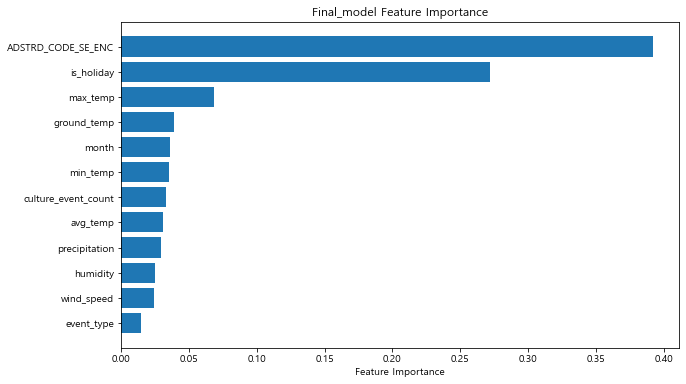

In [20]:
# Feature importance

import numpy as np

features = final_model.feature_names_in_
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), np.array(features)[indices])
plt.xlabel('Feature Importance')
plt.title('Final_model Feature Importance')
plt.gca().invert_yaxis()
plt.show()

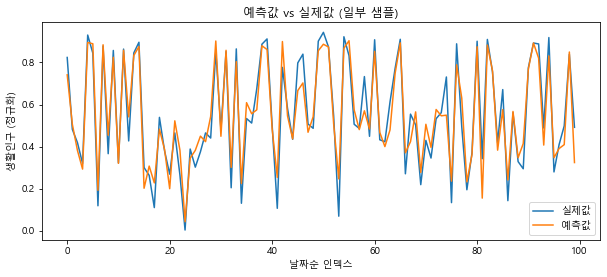

In [21]:
# 예측 vs 실제 그래프 

plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:100], label='실제값')
plt.plot(y_pred[:100], label='예측값')
plt.title('예측값 vs 실제값 (일부 샘플)')
plt.xlabel('날짜순 인덱스')
plt.ylabel('생활인구 (정규화)')
plt.legend()
plt.show()